In [1]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor,plot_importance
from scipy.stats import f_oneway
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [3]:
def data_preprocessing(past_sales_file, store_file):
    past_sales = pd.read_csv(past_sales_file)
    store = pd.read_csv(store_file)
    
    past_sales['Date'] = pd.to_datetime(past_sales['Date'], format="%Y-%m-%d") # 년도, 달, 일 순으로 format
    # a = 공휴일, b = 부활절 공휴일, c = 크리스마스, d = 없음
    past_sales['StateHoliday'] = past_sales['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
    past_sales['StateHoliday'] = past_sales['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체
    past_sales = past_sales.sort_values('Date') # date 기준으로 정렬
    past_sales = pd.get_dummies(data = past_sales,columns=['StateHoliday']) # StateHoliday를 더미 가변수로 대체, 결측값 없다는 거 확인 완료
    
    store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)
    store = pd.get_dummies(data = store, columns = ['Assortment']) # 규모를 더미 가변수로 대체, storetype = a에는 규모가 b인 상점은 없음
    
    # 결측값 확인 : past_sales.isnull().sum(), store_a.isnull().sum()
    # store의 CompetitionDistance에 3개 있음
    # 결측값 : 평균으로 대체
    store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean())
    
    # 병합
    data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')
    data = pd.get_dummies(data = data, columns = ['DayOfWeek']) # 요일 더미의 가변수로 추가
    data = pd.get_dummies(data = data, columns = ['StoreType'])
    data['Month']=pd.DatetimeIndex(data.Date).month
    data['Day']=pd.DatetimeIndex(data.Date).day
    data = data.drop(['Date'],axis=1) # 그래프 그릴려고 잠시 제거한 코드

    pd.options.display.max_columns = None

    
    return data

In [4]:
def data_normalization(past_sales_file, store_file):
    data = data_preprocessing(past_sales_file, store_file)
    
    scaler = StandardScaler().fit(data)
    data = pd.DataFrame(scaler.transform(data),index = data.index, columns = data.columns)
    
    return data

In [5]:
data = data_normalization('C:/Users/PC/표/수요예측/rossmann-store-sales/train.csv', 'C:/Users/PC/표/수요예측/rossmann-store-sales/store.csv')

C:\Users\PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
data

,Store,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c,StateHoliday_d,CompetitionDistance,Promo2,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Month,Day
0,-1.73164,-1.499723,-1.363330,-2.210440,-0.785400,2.144211,7.014824,-0.081366,-0.063616,-5.635633,-0.539891,-1.001128,0.944815,-0.090668,-0.929468,-0.407288,2.446069,-0.408821,-0.409116,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,2.536447,-0.666551,-1.457193,-1.673123
1,-1.73164,-0.063331,0.075050,0.452399,-0.785400,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.539891,-1.001128,0.944815,-0.090668,-0.929468,-0.407288,-0.408819,2.446060,-0.409116,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,2.536447,-0.666551,-1.457193,-1.559327
2,-1.73164,-0.375805,-0.118744,0.452399,-0.785400,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.539891,-1.001128,0.944815,-0.090668,-0.929468,-0.407288,-0.408819,-0.408821,2.444297,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,2.536447,-0.666551,-1.457193,-1.445530
3,-1.73164,-0.334505,-0.030460,0.452399,-0.785400,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.539891,-1.001128,0.944815,-0.090668,-0.929468,-0.407288,-0.408819,-0.408821,-0.409116,2.444297,-0.407288,-0.407288,-1.088491,-0.125731,2.536447,-0.666551,-1.457193,-1.331734
4,-1.73164,-0.201775,0.003992,0.452399,-0.785400,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.539891,-1.001128,0.944815,-0.090668,-0.929468,-0.407288,-0.408819,-0.408821,-0.409116,-0.409116,2.455264,-0.407288,-1.088491,-0.125731,2.536447,-0.666551,-1.457193,-1.217938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1.72897,1.282670,-0.054146,0.452399,1.273237,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.010385,0.998873,-1.058408,-0.090668,1.075884,2.455264,-0.408819,-0.408821,-0.409116,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,-0.394252,1.500261,0.346724,1.285581
1017205,1.72897,0.602397,-0.286698,0.452399,1.273237,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.010385,0.998873,-1.058408,-0.090668,1.075884,-0.407288,2.446069,-0.408821,-0.409116,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,-0.394252,1.500261,0.346724,1.399377
1017206,1.72897,0.490187,-0.344836,0.452399,1.273237,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.010385,0.998873,-1.058408,-0.090668,1.075884,-0.407288,-0.408819,2.446060,-0.409116,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,-0.394252,1.500261,0.346724,1.513173
1017207,1.72897,0.683437,-0.282392,0.452399,1.273237,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.010385,0.998873,-1.058408,-0.090668,1.075884,-0.407288,-0.408819,-0.408821,2.444297,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,-0.394252,1.500261,0.346724,1.626969


In [7]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
# features = features.values
# target = target.values

features_copy = []
target_copy = []

windows_size = 30
for i in range(len(features)-windows_size) :
    features_copy.append(np.array(features.iloc[i:i+windows_size]))
    target_copy.append(np.array(target.iloc[i:i+windows_size]))

In [8]:
np.array(features_copy).shape

(1017179, 30, 27)

In [9]:

x_train, x_valid, y_train, y_valid = train_test_split(features_copy, target_copy, test_size=0.2,random_state=1)

In [10]:
x_train = np.array(x_train)
x_valid = np.array(x_valid)

y_train = np.array(y_train)
y_valid = np.array(y_valid)


In [11]:
np.array(x_train).shape

(813743, 30, 27)

In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32,input_shape=(30,27),return_sequences=True))
model.add(tf.keras.layers.LSTM(32,return_sequences=True))
model.add(tf.keras.layers.LSTM(16,return_sequences=False))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 32)            7680      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 19,425
Trainable params: 19,425
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='mse',
             optimizer='adam',
             metrics=['mae'])

In [ ]:
history = model.fit(x_train,y_train,
                   validation_data = (x_valid,y_valid),
                   batch_size = 5,
                   epochs = 10)

Epoch 1/10
162749/162749 [==============================] - 4292s 26ms/step - loss: 0.7161 - mae: 0.6106 - val_loss: 0.7076 - val_mae: 0.6034
Epoch 2/10
 50879/162749 [========>.....................] - ETA: 43:05 - loss: 0.7040 - mae: 0.6020

In [ ]:
pred = model.predict(x_valid)
np.array(pred).shape

In [ ]:
y_valid = np.reshape(y_valid,(-1,1))

# pred_365 = pred[0:365]
# y_valid_365 = y_valid[0:365]

# fig = plt.figure(facecolor='white')
# ax = fig.add_subplot(111)
# ax.plot(y_valid_365, label='True')
# ax.plot(pred_365, label='Prediction')

# ax.legend()
# plt.show()


# pred = model.predict(test_x)
# test_y_1 = test_y_1.values.tolist()
# test_y_1 = np.array(test_y_1)
# fig = plt.figure(facecolor='white', figsize=(20, 10))
# ax = fig.add_subplot(111)
# ax.plot(test_y_1, label='True')
# ax.plot(pred, label='Prediction')
# ax.legend()
# plt.show()

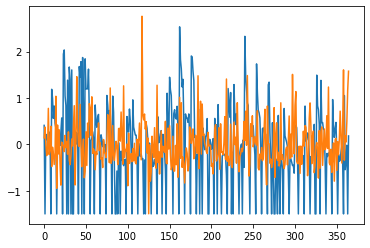

In [26]:
pred_365 = pred[0:365]
y_valid_365 = y_valid[0:365]

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_valid_365, label='True')
ax.plot(pred_365, label='Prediction')

In [27]:
from sklearn.metrics import r2_score
r2 = r2_score(y_valid, pred)
print(r2)

ValueError: Found input variables with inconsistent numbers of samples: [6103080, 203436]

In [20]:
np.array(pred).shape

(203436, 1)

In [21]:
np.array(y_valid).shape

(203436, 30, 1)

In [28]:
print(pred)

[[ 0.14149408]
 [ 0.37371007]
 [ 0.00686288]
 ...
 [-0.37740126]
 [-0.34295204]
 [ 0.67155874]]


In [29]:
print(y_valid)

[[ 0.40992521]
 [-1.49972273]
 [ 0.2169344 ]
 ...
 [ 2.04320409]
 [-1.49972273]
 [ 1.84761582]]


In [30]:
np.array(x_valid).shape

(203436, 30, 27)

In [32]:
y_train1 = target[0:len(x_train)]
y_valid1 = target[len(x_train):len(x_train)+len(x_valid)]

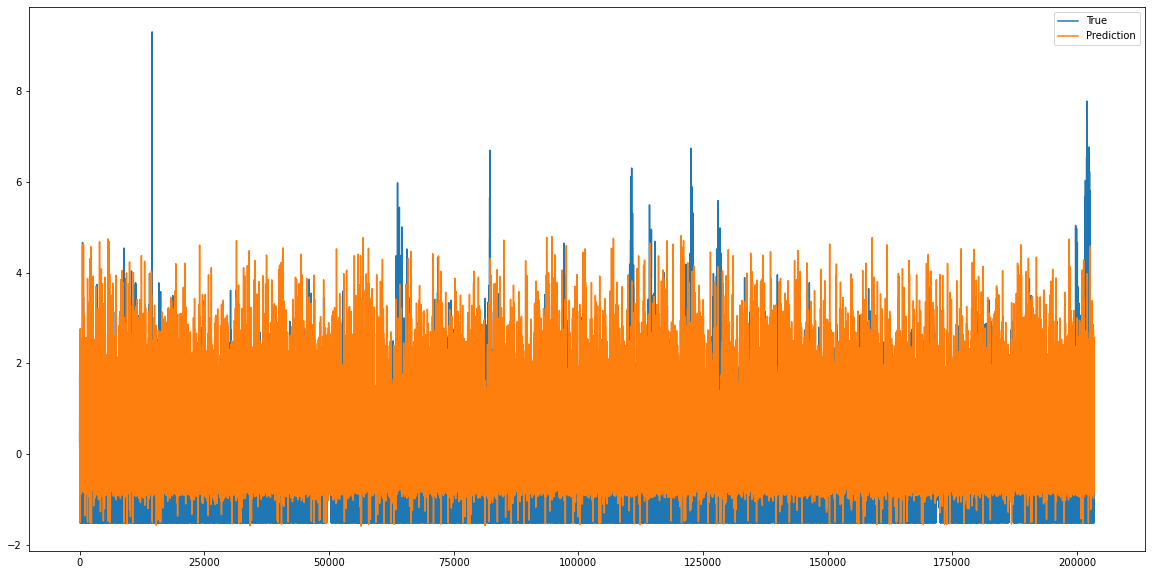

In [33]:

y_valid1 = y_valid1.values.tolist()
y_valid1 = np.array(y_valid1)
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_valid1, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

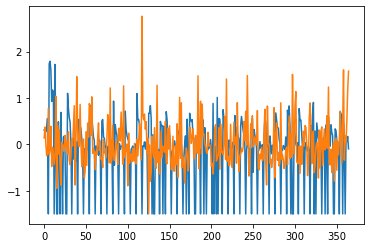

In [34]:
pred_365 = pred[0:365]
y_valid1_365 = y_valid1[0:365]

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_valid1_365, label='True')
ax.plot(pred_365, label='Prediction')

In [35]:
from sklearn.metrics import r2_score
r2 = r2_score(y_valid1, pred)
print(r2)

-0.32939794654571597


In [37]:
print(x_train)

[[[-7.06504276e-01  7.49021179e-01  4.52398520e-01 ... -6.66550702e-01
    4.60714237e-02  6.02802840e-01]
  [-7.06504276e-01 -2.52246004e-01  4.52398520e-01 ... -6.66550702e-01
    4.60714237e-02  7.16599123e-01]
  [-7.06504276e-01 -1.36332959e+00 -2.21044047e+00 ... -6.66550702e-01
    4.60714237e-02  8.30395405e-01]
  ...
  [-7.06504276e-01  6.73656983e-01  4.52398520e-01 ... -6.66550702e-01
    3.46724298e-01  2.61413993e-01]
  [-7.06504276e-01  5.10009013e-01  4.52398520e-01 ... -6.66550702e-01
    3.46724298e-01  3.75210275e-01]
  [-7.06504276e-01 -2.84544945e-01  4.52398520e-01 ... -6.66550702e-01
    3.46724298e-01  4.89006558e-01]]

 [[ 1.55190150e+00  5.13640453e-02  4.52398520e-01 ... -6.66550702e-01
   -2.54581451e-01  1.39937682e+00]
  [ 1.55190150e+00  4.26031765e-01  4.52398520e-01 ... -6.66550702e-01
   -2.54581451e-01  1.51317310e+00]
  [ 1.55190150e+00 -1.23050238e-01  4.52398520e-01 ... -6.66550702e-01
   -2.54581451e-01  1.62696938e+00]
  ...
  [ 1.55190150e+00  3.6

In [38]:
data

,Store,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c,StateHoliday_d,CompetitionDistance,Promo2,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Month,Day
0,-1.73164,-1.499723,-1.363330,-2.210440,-0.785400,2.144211,7.014824,-0.081366,-0.063616,-5.635633,-0.539891,-1.001128,0.944815,-0.090668,-0.929468,-0.407288,2.446069,-0.408821,-0.409116,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,2.536447,-0.666551,-1.457193,-1.673123
1,-1.73164,-0.063331,0.075050,0.452399,-0.785400,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.539891,-1.001128,0.944815,-0.090668,-0.929468,-0.407288,-0.408819,2.446060,-0.409116,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,2.536447,-0.666551,-1.457193,-1.559327
2,-1.73164,-0.375805,-0.118744,0.452399,-0.785400,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.539891,-1.001128,0.944815,-0.090668,-0.929468,-0.407288,-0.408819,-0.408821,2.444297,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,2.536447,-0.666551,-1.457193,-1.445530
3,-1.73164,-0.334505,-0.030460,0.452399,-0.785400,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.539891,-1.001128,0.944815,-0.090668,-0.929468,-0.407288,-0.408819,-0.408821,-0.409116,2.444297,-0.407288,-0.407288,-1.088491,-0.125731,2.536447,-0.666551,-1.457193,-1.331734
4,-1.73164,-0.201775,0.003992,0.452399,-0.785400,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.539891,-1.001128,0.944815,-0.090668,-0.929468,-0.407288,-0.408819,-0.408821,-0.409116,-0.409116,2.455264,-0.407288,-1.088491,-0.125731,2.536447,-0.666551,-1.457193,-1.217938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1.72897,1.282670,-0.054146,0.452399,1.273237,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.010385,0.998873,-1.058408,-0.090668,1.075884,2.455264,-0.408819,-0.408821,-0.409116,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,-0.394252,1.500261,0.346724,1.285581
1017205,1.72897,0.602397,-0.286698,0.452399,1.273237,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.010385,0.998873,-1.058408,-0.090668,1.075884,-0.407288,2.446069,-0.408821,-0.409116,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,-0.394252,1.500261,0.346724,1.399377
1017206,1.72897,0.490187,-0.344836,0.452399,1.273237,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.010385,0.998873,-1.058408,-0.090668,1.075884,-0.407288,-0.408819,2.446060,-0.409116,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,-0.394252,1.500261,0.346724,1.513173
1017207,1.72897,0.683437,-0.282392,0.452399,1.273237,2.144211,-0.142555,-0.081366,-0.063616,0.177442,-0.010385,0.998873,-1.058408,-0.090668,1.075884,-0.407288,-0.408819,-0.408821,2.444297,-0.409116,-0.407288,-0.407288,-1.088491,-0.125731,-0.394252,1.500261,0.346724,1.626969
